<div class="alert alert-primary alert-info">

# Gaussian Process の 事

</div>

---

Gaussian distribution

Let $ \mathbf{X} = \{ X_i \}_{i=1}^n \sim \mathcal{N}\left( \mathbf{\mu}, \Sigma \right) $

$ f(\mathbf{x}) = (2\pi)^{-n/2} (| \Sigma |)^{-1/2} e^{ -\frac{1}{2} (\mathbf{x}-\mathbf{\mu})^T \Sigma^{-1} (\mathbf{x}-\mathbf{\mu}) } $, $\mathbf{x} \in \mathbb{R}^n$, $\Sigma \in \mathbb{R}^{n \times n}$

$ \{ X_i \}_{i=1}^n \iff \mathbf{c}^\intercal \mathbf{X} \sim \mathcal{N}(\mu, \sigma) $, $ \forall \mathbf{c} \in \mathbb{R}^n, \mu \in \mathbb{R}, \sigma \in \mathbb{R}$

Let $ \mathbf{X} =
\begin{bmatrix}
\mathbf{X_1}\\
\mathbf{X_2}
\end{bmatrix},
\mathbf{\mu} = 
\begin{bmatrix}
\mu_{x_1}\\
\mu_{x_2}
\end{bmatrix},
\mathbf{\Sigma} =
\begin{bmatrix}
\Sigma_{x_1 x_1} & \Sigma_{x_1 x_2}\\
\Sigma_{x_2 x_1} & \Sigma_{x_2 x_2}
\end{bmatrix}
$

$ p(x_1) = \int p(x_1, x_2) dx_2 $, $\mathbf{X_1} \sim \mathcal{N}(\mu_{x_1}, \Sigma_{x_1 x_1})$

$ p(x_2) = \int p(x_1, x_2) dx_1 $, $\mathbf{X_2} \sim \mathcal{N}(\mu_{x_2}, \Sigma_{x_2 x_2})$

$ ( \mathbf{X_1} \mid \mathbf{X_2} = x_2) \sim \mathcal{N}( \mu_{X_1}+\Sigma_{X_1 X_2} \Sigma^{-1}_{X_1 X_1}(x_2-\mu_{X_2}), \Sigma_{X_1 X_1}-\Sigma_{X_1 X_2} \Sigma_{X_1 X_1}^{-1} \Sigma_{X_1 X_2}^{\top})$

---

Gaussian process regression

$ \mathbf{X} \sim \mathcal{N}\left( \mathbf{\mu}, \Sigma \right) $ Distribution over random vectors.

$ f(\mathbf{X}) \sim \mathcal{GP}(\mu_{\mathbf{X}}, k(\mathbf{X}, \mathbf{X}^{\prime}))$ Distribution over functions. Intuitively, $\mu \in \mathbb{R}^{\infty}$, $k \in \mathbb{R}^{\infty \times \infty}$

For the training set, let $\mathbf{x} = \{ x_i \}_{i=1}^n$ be the domain, $\mathbf{y} = \{ y_i \}_{i=1}^n$ be a sampled path of $\mathbf{f} = \{ f(x_i) \}_{i=1}^n$

$\mathbf{f}(\mathbf{x}) \sim \mathcal{N}(0, K(\mathbf{x}, \mathbf{x}))$ and we want to infer $\mathbf{f^{\prime}}$

$\begin{bmatrix}
\mathbf{f}\\
\mathbf{f^{\prime}}
\end{bmatrix}
\sim
\mathcal{N}
(
0,
\begin{bmatrix}
K(X, X) & K(X, X^{\prime}) \\
K(X^{\prime}, X) & K(X^{\prime}, X^{\prime})
\end{bmatrix}
)
$

$ ( \mathbf{f^{\prime}} \mid \mathbf{f} = \mathbf{y} ) \sim \mathcal{N}( \mu_{\mathbf{f}^{\prime}}+\Sigma_{\mathbf{f}^{\prime} \mathbf{f}} \Sigma^{-1}_{\mathbf{f} \mathbf{f}} \mathbf{y}, \Sigma_{\mathbf{f}^{\prime} \mathbf{f}^{\prime}}-\Sigma_{\mathbf{f}^{\prime} \mathbf{f}} \Sigma_{\mathbf{f} \mathbf{f}}^{-1} \Sigma_{\mathbf{f}^{\prime} \mathbf{f}}^{\top})$

$\mathcal{O}(n^3)$ matrix inversion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
def squared_exponential_kernel(x1, x2, l=1.0):
    x_i, x_j = np.meshgrid(x1, x2)
    return np.exp(-(((x_i - x_j)**2.0) / (2.0*l**2.0)))

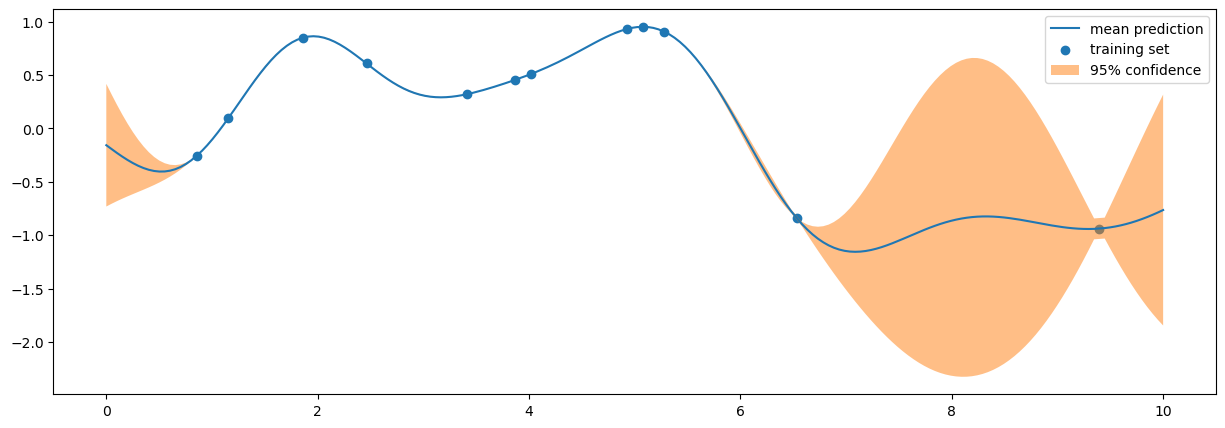

In [3]:
train_size = 12
X_size = 200

random_indices = sorted(np.random.choice(np.arange(X_size), train_size, replace=False))
X = np.linspace(0, 10, 200)
X_train = X[random_indices]

K_f_f = squared_exponential_kernel(X_train, X_train)
mu_f = np.zeros(K_f_f.shape[0])

Y = np.random.multivariate_normal(mu_f, K_f_f, 1).T  #sampled path

X_test = np.setdiff1d(X, X_train)

K_fp_f = squared_exponential_kernel(X_train, X_test)
mu_fp = K_fp_f @ np.linalg.inv(K_f_f) @ Y

K_fp_fp = squared_exponential_kernel(X_test, X_test)
std_fp_fp = np.sqrt(np.diag(K_fp_fp - K_fp_f @ np.linalg.inv(K_f_f) @ K_fp_f.T))

plt.figure(figsize=(15,5))
plt.plot(X_test, mu_fp, label='mean prediction')
plt.scatter(X_train, Y, label='training set')
plt.fill_between(
    X_test,
    mu_fp.ravel() - 1.96 * std_fp_fp,
    mu_fp.ravel() + 1.96 * std_fp_fp,
    alpha=0.5,
    label='95% confidence')
plt.legend();

---

#### With Scikit-Learn

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

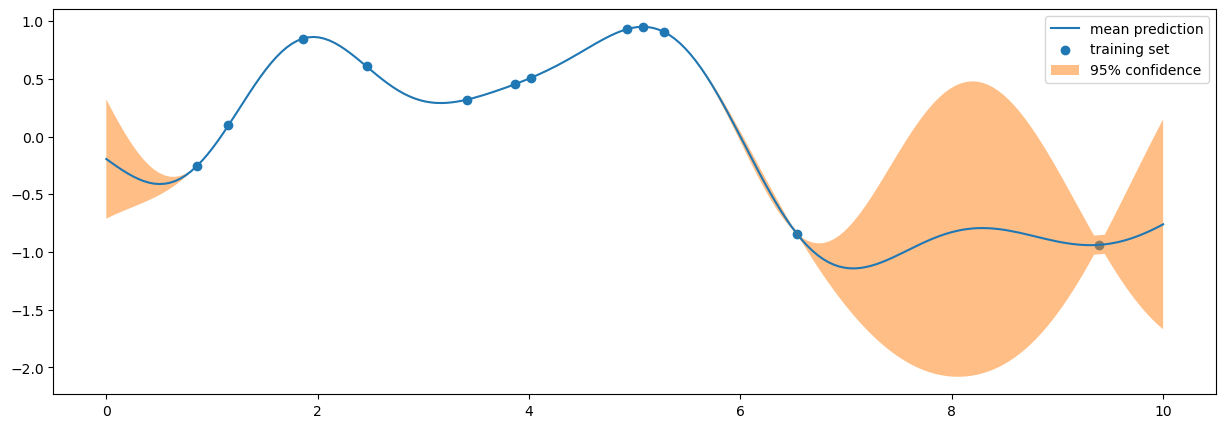

In [5]:
kernel = 1.0 * RBF(length_scale=1.0)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gp.fit(X_train[:, np.newaxis], Y)

mean_prediction, std_prediction = gp.predict(X_test[:, np.newaxis], return_std=True)

plt.figure(figsize=(15, 5))
plt.plot(X_test, mean_prediction, label='mean prediction')
plt.scatter(X_train, Y, label='training set')
plt.fill_between(
    X_test,
    mean_prediction.ravel() - 1.96 * std_prediction,
    mean_prediction.ravel() + 1.96 * std_prediction,
    alpha=0.5,
    label='95% confidence')
plt.legend();

---

#### Yet another one

---

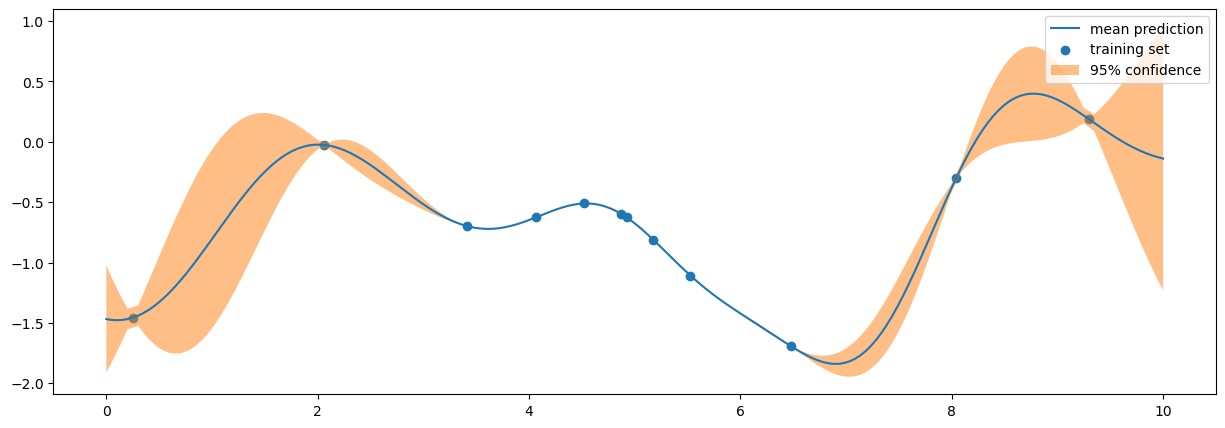

In [6]:
train_size = 12
X_size = 200

random_indices = sorted(np.random.choice(np.arange(X_size), train_size, replace=False))
X = np.linspace(0, 10, 200)
X_train = X[random_indices]

K_f_f = squared_exponential_kernel(X_train, X_train)
mu_f = np.zeros(K_f_f.shape[0])

Y = np.random.multivariate_normal(mu_f, K_f_f, 1).T  #sampled path

X_test = np.setdiff1d(X, X_train)

K_fp_f = squared_exponential_kernel(X_train, X_test)
mu_fp = K_fp_f @ np.linalg.inv(K_f_f) @ Y

K_fp_fp = squared_exponential_kernel(X_test, X_test)
std_fp_fp = np.sqrt(np.diag(K_fp_fp - K_fp_f @ np.linalg.inv(K_f_f) @ K_fp_f.T))

plt.figure(figsize=(15,5))
plt.plot(X_test, mu_fp, label='mean prediction')
plt.scatter(X_train, Y, label='training set')
plt.fill_between(
    X_test,
    mu_fp.ravel() - 1.96 * std_fp_fp,
    mu_fp.ravel() + 1.96 * std_fp_fp,
    alpha=0.5,
    label='95% confidence')
plt.legend();

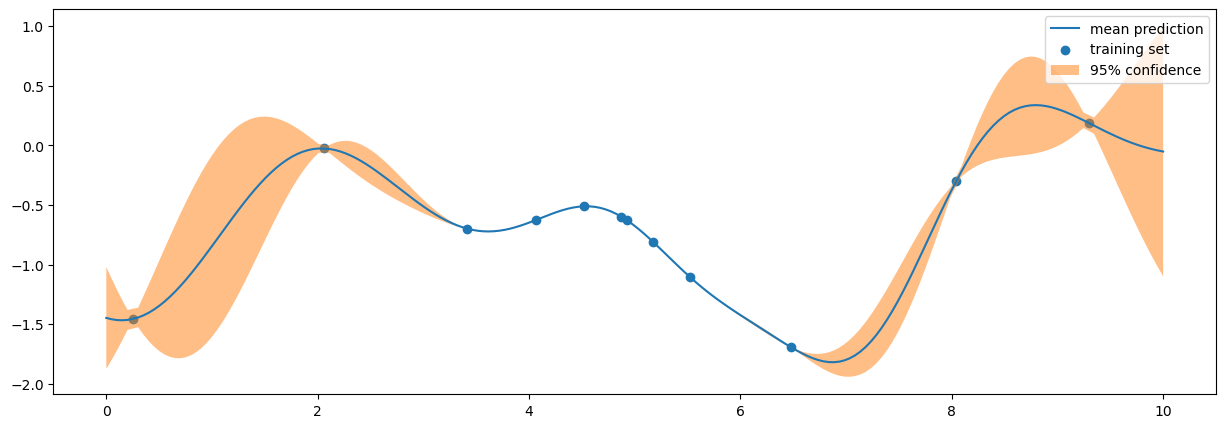

In [7]:
kernel = 1.0 * RBF(length_scale=1.0)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gp.fit(X_train[:, np.newaxis], Y)

mean_prediction, std_prediction = gp.predict(X_test[:, np.newaxis], return_std=True)

plt.figure(figsize=(15, 5))
plt.plot(X_test, mean_prediction, label='mean prediction')
plt.scatter(X_train, Y, label='training set')
plt.fill_between(
    X_test,
    mean_prediction.ravel() - 1.96 * std_prediction,
    mean_prediction.ravel() + 1.96 * std_prediction,
    alpha=0.5,
    label='95% confidence')
plt.legend();